# kobert_with_data_augmentation

In [ ]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_star = pd.read_csv('/content/drive/MyDrive/try_230603/df_star_eda.csv',encoding='utf-8-sig')
df_no_star = pd.read_csv('/content/drive/MyDrive/try_230603/df_no_star_230603.csv',encoding='utf-8-sig')

In [ ]:
len(df_star),len(df_no_star)

(398268, 669029)

In [ ]:
df_star = df_star.drop_duplicates()
df_no_star = df_no_star.drop_duplicates()

In [ ]:
len(df_star),len(df_no_star)

(398268, 669029)

In [ ]:
df_star = df_star.dropna()
df_no_star = df_no_star.dropna()

In [ ]:
len(df_star),len(df_no_star)

(398266, 669028)

In [ ]:
df_star.reset_index(drop=True, inplace=True)
df_no_star.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

# df_star 데이터프레임을 train과 test로 나누기 위해 train_test_split 함수를 사용한다.
# test_size는 test 데이터셋의 비율을 의미한다.
# random_state는 난수 발생 시드값으로, 같은 시드값을 사용하면 같은 결과를 얻을 수 있다.
train, test = train_test_split(df_star, test_size=0.2, random_state=42,stratify=df_star['rating'])



In [ ]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)


In [ ]:
len(train),len(test)

(318612, 79654)

In [ ]:

test['rating'].value_counts(),train['rating'].value_counts()

(1    51305
 0    28349
 Name: rating, dtype: int64,
 1    205216
 0    113396
 Name: rating, dtype: int64)

## 버트 인풋 만들기

한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.
이번에는 한국어 데이터로 훈련되었고, SKT에서 만든 KoBERT를 사용하도록 하겠습니다.
모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.
huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.
https://github.com/monologg/KoBERT-NER 에서 kobert를 tokenize 할 수 있는 코드를 가져왔습니다.

In [ ]:
# KoBERT 토크나이저를 활용

import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece `_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

loading file tokenizer_78b3253a26.model from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/tokenizer_78b3253a26.model
loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/config.json
Model config BertConfig {
  "_name_or_path": "monologg/kobert",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Be

In [ ]:
def convert_data(data_df):
    global tokenizer

    SEQ_LEN = 64  # SEQ_LEN : 버트에 들어갈 인풋의 길이

    tokens, masks, segments, targets = [], [], [], []

    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(
            data_df[DATA_COLUMN][i], truncation=True, padding='max_length', max_length=SEQ_LEN)

        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros

        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)

        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의


def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y


SEQ_LEN = 64
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "review_content"
# 긍정인지 부정인지를 (1=긍정,0=부정) 포함하고 있는 칼럼
LABEL_COLUMN = "rating"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)


100%|██████████| 318612/318612 [01:15<00:00, 4222.20it/s]


In [ ]:
train_x

[array([[   2, 1540,  517, ...,    1,    1,    1],
        [   2, 4297, 7119, ...,    1,    1,    1],
        [   2, 5103, 3136, ...,   54, 5561,    3],
        ...,
        [   2,  517, 5796, ...,    1,    1,    1],
        [   2, 3214, 5859, ...,    1,    1,    1],
        [   2, 4192, 6164, ...,    1,    1,    1]]),
 array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 79654/79654 [00:17<00:00, 4438.86it/s]


## 버트를 활용한 감성분석 모델 만들기

In [ ]:
model = TFBertModel.from_pretrained(
    "monologg/kobert", from_pt=True)  # monologg/kobert 모델 불러오기


# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input(
    (SEQ_LEN,), dtype=tf.int32, name='input_word_ids')  # 입력 토큰 정의
mask_inputs = tf.keras.layers.Input(
    (SEQ_LEN,), dtype=tf.int32, name='input_masks')  # 입력 마스크 정의
segment_inputs = tf.keras.layers.Input(
    (SEQ_LEN,), dtype=tf.int32, name='input_segment')  # 입력 세그먼트 정의


# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model(
    [token_inputs, mask_inputs, segment_inputs])  # bert 모델의 출력 정의


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/config.json
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/pytorch_model.bin
Loading PyTorch weights from /root/.cache/huggingface/hub/models--monologg--kobert/snapshots/8ebf2818cfd85570737d31ed8cd7aaa000e7056c/pytorch_model.bin
PyTorch checkpoint contains 92,186,880 parameters
Loaded 92,186,880 parameters in the TF 2.0 model.
All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 64, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [ ]:
bert_outputs = bert_outputs[1]

In [ ]:
bert_outputs[1]

<KerasTensor: shape=(768,) dtype=float32 (created by layer 'tf.__operators__.getitem')>

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.5 MB/s eta 0:00:00


In [ ]:
# Rectified Adam 옵티마이저 사용
# tensorflow_addons 패키지 설치
import tensorflow_addons as tfa

# 총 batch size * 4 epoch = 2344 * 4
# Rectified Adam 옵티마이저 생성
opt = tfa.optimizers.RectifiedAdam(
    lr=5.0e-5,  # learning rate 설정
    total_steps=2344*2,  # 총 스텝 수 설정
    warmup_proportion=0.1,  # warmup 비율 설정
    
)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:121: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

sentiment_drop = tf.keras.layers.Dropout(
    0.5)(bert_outputs)  # BERT 출력값에 드롭아웃 적용
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(
    stddev=0.02))(sentiment_drop)  # 드롭아웃 적용된 BERT 출력값에 fully connected layer 적용
sentiment_model = tf.keras.Model(
    [token_inputs, mask_inputs, segment_inputs], sentiment_first)  # 입력값과 출력값을 지정하여 모델 생성
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[
                        'acc'])  # 모델 컴파일, optimizer는 Adam, loss는 binary crossentropy, 평가 지표는 accuracy


In [ ]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 64)]         0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

In [ ]:
# GPU를 사용하기 위해 런타임 유형을 GPU로 변경

# 필요한 라이브러리 import
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=4)


# GPU를 사용하기 위한 설정
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# 모델 학습
with tf.device('/device:GPU:0'):
  history = sentiment_model.fit(train_x, train_y, epochs=5, shuffle=True,
                      batch_size=64,callbacks=es, validation_data=(test_x, test_y))


Found GPU at: /device:GPU:0
Epoch 1/5
4979/4979 [==============================] - 581s 117ms/step - loss: 0.2536 - acc: 0.8967 - val_loss: 0.1809 - val_acc: 0.9308
Epoch 2/5
4979/4979 [==============================] - 579s 116ms/step - loss: 0.1673 - acc: 0.9372 - val_loss: 0.1809 - val_acc: 0.9308
Epoch 3/5
4979/4979 [==============================] - 579s 116ms/step - loss: 0.1675 - acc: 0.9371 - val_loss: 0.1809 - val_acc: 0.9308
Epoch 4/5
4979/4979 [==============================] - 578s 116ms/step - loss: 0.1672 - acc: 0.9375 - val_loss: 0.1809 - val_acc: 0.9308
Epoch 5/5
4979/4979 [==============================] - 584s 117ms/step - loss: 0.1672 - acc: 0.9372 - val_loss: 0.1809 - val_acc: 0.9308
Epoch 5: early stopping


In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []

    for i in tqdm(range(len(data_df))):  # 데이터프레임의 길이만큼 반복문 실행

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN,
                                 truncation=True, padding='max_length')  # 문장을 토큰화하여 인코딩
        num_zeros = token.count(0)  # 0의 개수를 세어 num_zeros에 저장
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros  # mask 생성
        segment = [0]*SEQ_LEN  # segment 생성

        tokens.append(token)  # tokens 리스트에 token 추가
        segments.append(segment)  # segments 리스트에 segment 추가
        masks.append(mask)  # masks 리스트에 mask 추가

    tokens = np.array(tokens)  # tokens 리스트를 numpy 배열로 변환
    masks = np.array(masks)  # masks 리스트를 numpy 배열로 변환
    segments = np.array(segments)  # segments 리스트를 numpy 배열로 변환
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의


def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(
        str)  # 데이터프레임의 DATA_COLUMN 열을 문자열로 변환
    data_x = predict_convert_data(data_df)  # convert_data 함수를 이용하여 데이터 전처리
    return data_x


In [ ]:

test_set = predict_load_data(test)

100%|██████████| 79654/79654 [00:19<00:00, 4038.02it/s]


In [ ]:
test_set

[array([[   2,  993, 5568, ...,    1,    1,    1],
        [   2, 1680, 5872, ...,    1,    1,    1],
        [   2,  781, 5965, ...,    1,    1,    1],
        ...,
        [   2, 1458, 1967, ...,  830, 6827,    3],
        [   2, 3803, 7782, ..., 7654, 5586,    3],
        [   2,  517, 5796, ...,    1,    1,    1]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
preds = sentiment_model.predict(test_set)

2490/2490 [==============================] - 68s 26ms/step


In [ ]:

# 부정이면 0, 긍정이면 1 출력
preds

array([[0.02574962],
       [0.9978508 ],
       [0.99106836],
       ...,
       [0.99614847],
       [0.00429459],
       [0.9959486 ]], dtype=float32)

In [ ]:

from sklearn.metrics import classification_report
y_true = test['rating']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     28349
           1       0.93      0.96      0.95     51305

    accuracy                           0.93     79654
   macro avg       0.93      0.92      0.92     79654
weighted avg       0.93      0.93      0.93     79654



- 부정데이터의 증강으로 부정리뷰에 대한 예측의 정확도가 상당히 올라간 것을 확인했다.

In [ ]:
import logging  # logging 모듈을 import 합니다.
tf.get_logger().setLevel(logging.ERROR)  # tensorflow의 logger를 ERROR 레벨로 설정합니다.


In [ ]:

def sentence_convert_data(data):
    global tokenizer
    tokens, masks, segments = [], [], []
    token = tokenizer.encode(data, max_length=SEQ_LEN,
                             truncation=True, padding='max_length')

    num_zeros = token.count(0)  # 패딩으로 추가된 0의 개수를 세어준다.
    mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros  # 패딩 부분은 0으로 마스킹한다.
    segment = [0]*SEQ_LEN  # 문장의 길이만큼 segment를 0으로 채운다.

    tokens.append(token)
    segments.append(segment)
    masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]


def review_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = sentiment_model.predict(data_x)
    predict_value = np.ravel(predict)
    predict_answer = np.round(predict_value, 0).item()

    if predict_answer == 0:
      # 예측값이 0일 경우, 부정적인 평가로 판단한다.
      print(sentence)
      print("(부정 확률 : %.2f) 부정적인 평가입니다." % (1-predict_value))
      print('='*60)
    # elif predict_answer == 1:
    #   # 예측값이 1일 경우, 긍정적인 평가로 판단한다.
    #   print(sentence)
    #   print("(긍정 확률 : %.2f) 긍정적인 평가입니다." % predict_value)
    #   print('='*60)


## 모델 저장

In [ ]:
sentiment_model.save_weights("/content/drive/MyDrive/try_230603/ckpt_230604_eda_data")

In [ ]:
df_no_star[df_no_star['review_content'].notnull()].iloc[0,0]

'안주물회 먹었어요  새벽2시까지 영업해요'

In [ ]:
for each in df_no_star['review_content'][300:1000]:
  review_evaluation_predict(each)

1/1 [==============================] - 0s 45ms/step
어머낫     직원휴게공간이 안쪽에 없으실까요      한쪽 테이블에서 입구쪽을 향해 주무시는 직원분     우르르 몰려계시는 모습 등을 보고   어떠케 생각해.야할지 난감   들어가야할지   나가야할지    암튼     좀 개선은 필요할듯 
(부정 확률 : 0.97) 부정적인 평가입니다.
1/1 [==============================] - 0s 44ms/step
헉 정말 배달음식보다 못해요        옛날 명성 사보텐이 그립네요 카츠동은 너무 짜고 돈까스 고기는 퍽퍽 아랫부분은 눅눅           
(부정 확률 : 0.99) 부정적인 평가입니다.
1/1 [==============================] - 0s 46ms/step
평범합니다   우동은 별로     
(부정 확률 : 0.91) 부정적인 평가입니다.
1/1 [==============================] - 0s 40ms/step
별로
(부정 확률 : 0.91) 부정적인 평가입니다.
1/1 [==============================] - 0s 39ms/step
컵엔 말라붙은 팽이버섯  다른 테이블이 주문한 음식 아니라는데도 굳이 그 테이블에 놨다가 다시 챙겨 우리 테이블에 갖다주는      불친절한건 기본인듯.코로나시국에 위생도 불결하고 다시는안감
(부정 확률 : 1.00) 부정적인 평가입니다.
1/1 [==============================] - 0s 42ms/step
돈가스 기본은 해요
(부정 확률 : 0.55) 부정적인 평가입니다.
1/1 [==============================] - 0s 41ms/step
맛있긴한데 비쌈   시간대가 식사시간대이면 웨이팅 좀 있음
(부정 확률 : 0.50) 부정적인 평가입니다.
1/1 [==============================] - 0s 41ms/step
사장님 

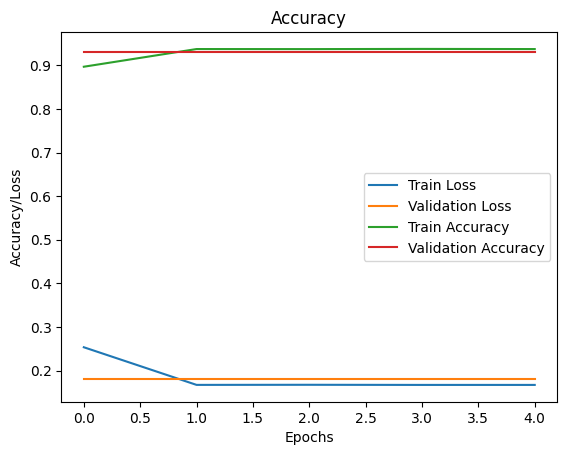

In [ ]:
import matplotlib.pyplot as plt

# 손실값을 시각화합니다.
# 정확도를 시각화합니다.

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()
